In [ ]:
!pip install moviepy
!pip install librosa
!pip install scipy
!pip install matplotlib
!pip install pedalboard
!pip install ffmpeg-python # better audio extraction

In [33]:
import numpy as np
import librosa
from moviepy.editor import VideoFileClip, concatenate_videoclips
import scipy 
from pedalboard import Pedalboard, Chorus, Reverb, NoiseGate
from pedalboard.io import AudioFile
import ffmpeg
import os
from scipy.io import wavfile
from moviepy.editor import AudioFileClip, AudioClip
import os
from pedalboard import Pedalboard, Chorus, Reverb, Limiter

def get_audio_sample_rate(video_file):
    probe = ffmpeg.probe(video_file, v='quiet', select_streams='a:0', show_entries='stream=sample_rate')
    if 'streams' in probe and len(probe['streams']) > 0:
        return int(probe['streams'][0]['sample_rate'])
    else:
        return 0  # No audio or first audio track not found

def count_audio_channels(video_file):
    probe = ffmpeg.probe(video_file, v='quiet', select_streams='a:0', show_entries='stream=channels')
    if 'streams' in probe and len(probe['streams']) > 0:
        return int(probe['streams'][0]['channels'])
    else:
        return 0  # No audio or first audio track not found

def extract_audio_data(video_file):
    """
    extracts the audio track from the video file and returns it as an
    array of samples. If 2 channels, returns average values for simplicity 
    """
    sr = get_audio_sample_rate(video_file)
    channels = count_audio_channels(video_file)
    audio, _ = (
        ffmpeg.input(video_file)
        .output("pipe:", format="f32le", acodec="pcm_f32le")
        .run(capture_stdout=True)
    )
    audio_array = np.frombuffer(audio, dtype=np.float32)
    # based on number of channels, re-arrange the array
    assert channels <= 2, "Cannot cope with more than two channels yet"
    if channels == 2:
        audio_array = (audio_array[0::2] + audio_array[1::2]) / 2        
    return audio_array, sr

def find_highest_elements(arr1, arr2):
    """
    returns an array of the same length as arr1 and arr2
    for each step in the new array, if arr1[step] > arr2[step], write 0, otherwise, 1
    """
    if len(arr1) != len(arr2):
        raise ValueError("Input arrays must have the same length")
    result = [0 if l1 > l2 else 1 for l1, l2 in zip(arr1, arr2)]
    return np.array(result)

def process_repeats(input, thresh = 100):
    """
    work through values in input, writing current value 
    to an output
    once you've seen any value > thresh times, 
    switch to that value as your output value 
    and reset counts so the race to take over starts again
    """
    vals = np.unique(input)
    counts = {}
    for v in vals: counts[v] = 0 
    current = vals[0]
    output = np.zeros(len(input))
    for i in range(len(input)):# iterate input
        counts[input[i]] += 1 # log count for input at step i
        for k in counts.keys(): # look for count > thresh
            if counts[k] > thresh: # value k is over thresh
                current = k
                # reset counters
                for k in counts.keys(): counts[k] = 0
        output[i] = current
    return output




def test_find_highest_elements():
    # Example usage:
    arr1 = np.array([1, 2, 3, 4, 5])
    arr2 = np.array([5, 4, 3, 2, 1])
    
    result = find_highest_elements(arr1, arr2)
    print("Comparison Result:", result)



def count_repeats(arr):
    """
    used to create the segment descriptors: [[0, 123], [1, 2323]]
    where the first value is the array value, the second is the number of repeats
    iterates over the sent 1D array, counting the length of repeating sequences
    when the value changes, counter is set to zero
    outputs a list of values encountered and how many repeats of each it sees
    """
    lens = []
    count = 0
    val = arr[0]
    for x in arr:
        if x == val: # no change
            count += 1
        else: # change
            lens.append([val, count])
            val = x
            count = 0
    return lens
    
def create_video_edit_moviepy(video_paths, segment_descriptors):
    clips = []
    offset = 0  # Initialize the offset
    videos = [VideoFileClip(p) for p in video_paths]
    #for video_index, duration in segment_descriptors:
    for seg_pair in segment_descriptors:
        video_index = int(seg_pair[0])
        duration = seg_pair[1]
        # video_path = video_paths[video_index]
        # clip = VideoFileClip(video_path).subclip(offset, offset + duration)
        clip = videos[video_index].subclip(offset, offset + duration)
        clips.append(clip)
        offset += duration  # Accumulate the offset for the next segment

    final_clip = concatenate_videoclips(clips)
    # final_clip.write_videofile(output_path, codec='libx264')
    
    print(f'Video edit created')
    return final_clip


def remux_video(video_file, audio_file):
    input_video = video_file
    new_audio = audio_file
    output_video = video_file[0:-4] + "-mixed" + video_file[:-4]
    
    # Define the input video and audio streams
    input_video_stream = ffmpeg.input(input_video)
    input_audio_stream = ffmpeg.input(new_audio)
    
    # Use the 'map' option to copy the video stream and the audio stream
    output_stream = ffmpeg.output(input_video_stream['v'], input_audio_stream['a'], output_video, c='copy')
    
    # Run the ffmpeg command to replace the audio using the copy codec
    ffmpeg.run(output_stream, overwrite_output=True)

    import tempfile


def buffer_to_audioclip(buffer, sr=48000):
    """
    converts the sent buffer of samples into a moviepy audio clip
    by writing to a file then reading back in
    """
    with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as temp_audio_file:
        temp_audio_filename = temp_audio_file.name
        # this write should retain the buffer data as 32 bit floats
        wavfile.write(temp_audio_filename, sr, buffer)
    # 
    audio_clip = AudioFileClip(temp_audio_filename) 
    os.remove(temp_audio_filename)
    return audio_clip


def apply_gate(audio_data, sr=48000, gate_threshold_db=-25):
    board = Pedalboard([
        #Chorus(), Reverb(room_size=0.25)
        NoiseGate(gate_threshold_db, release_ms=200, attack_ms=10)
    ])
    effected = board(audio_data, sr, reset=True)
    return effected 

 # class pedalboard.Limiter(threshold_db: float = -10.0, release_ms: float = 100.0)
def apply_limit(audio_data, sr=48000, limit_threshold_db=-6):
    board = Pedalboard([
        #Chorus(), Reverb(room_size=0.25)
        Limiter(threshold_db=limit_threshold_db)#, release_ms=300, attack_ms=10)
    ])
    effected = board(audio_data, sr, reset=True)
    return effected 
    
def normalise(audio):
    # Find the maximum absolute value in the array
    max_abs_value = np.max(np.abs(audio))
    print("adding gain", 1/max_abs_value)
    # Normalize the array to the range -1 to 1
    normalized_array = audio / max_abs_value
    return normalized_array 

def loudness_stats(samples, block_size=512):
    offset = 1e-6
    samples = samples + offset
    
    # Calculate the number of blocks
    num_blocks = len(samples) // block_size
    
    # Initialize an array to store the RMS values
    rms_values = np.zeros(num_blocks)
    
    # Calculate RMS in blocks
    for i in range(num_blocks):
        block = samples[i * block_size : (i + 1) * block_size]
        rms_values[i] = np.sqrt(np.mean(block ** 2))

    # Step 1: Calculate the loudness (in dB) for each sample
    loudness_dB = 20 * np.log10(np.abs(rms_values))
    # Step 2: Compute the mean (average) of the loudness values
    mean_loudness = np.mean(loudness_dB)
    
    # Step 3: Calculate the standard deviation of the loudness values
    std_deviation_loudness = np.std(loudness_dB)
    print(f"Mean loudness in dB: {mean_loudness:.2f} dB")
    print(f"Standard deviation of loudness in dB: {std_deviation_loudness:.2f} dB")
    return {"rms_mean":mean_loudness, "rms_std":std_deviation_loudness}


def loudness_stats_old(samples):
    samples = np.array(samples)
    # print("analysing samples: ", len(samples))
    # stop zeros...
    offset = 1e-6
    samples = samples + offset
    # Step 1: Calculate the loudness (in dB) for each sample
    loudness_dB = 20 * np.log10(np.abs(samples))
    
    # Step 2: Compute the mean (average) of the loudness values
    mean_loudness = np.mean(loudness_dB)
    
    # Step 3: Calculate the standard deviation of the loudness values
    std_deviation_loudness = np.std(loudness_dB)
    
    print(f"Mean loudness in dB: {mean_loudness:.2f} dB")
    print(f"Standard deviation of loudness in dB: {std_deviation_loudness:.2f} dB")
    return {"rms_mean":mean_loudness, "rms_std":std_deviation_loudness}


# def loudness_stats(buffer):
#     # Step 1: Calculate the root mean square (RMS)
#     rms = np.sqrt(np.mean(buffer ** 2))
#     rmsd = np.sqrt(np.std(buffer ** 2))
    
#     # Step 2: Convert RMS to dB
#     loudness_dB = 20 * np.log10(rms)
#     loudness_dB_std = 20 * np.log10(rmsd)
    
#     print(f"Median loudness in dB: {loudness_dB:.2f} dB")
#     print(f"SD: {loudness_dB_std:.2f} dB")
#     return loudness_dB
   

# load the clips

In [6]:

video_paths = ['../data/matthew-aligned.mov', '../data/mark-aligned.mov']
assert os.path.exists(video_paths[0]), video_paths[0] + " not found "
assert os.path.exists(video_paths[1]), video_paths[1] + " not found "

clip1,sr = extract_audio_data(video_paths[0])
clip2,sr = extract_audio_data(video_paths[1])




ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.1.0.2.5)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopen

## analysis example

In [13]:
## compute moving average
print("Reading files")
sr = 48000
# frame_size = sr/2 # for the moving average filter
window_size = round(0.5 * sr)  

hits_to_switch = sr # how many 'loudest frame' hits needed to switch to that track? 

print("Computing moving average for", (len(clip1) / sr), "seconds")

# clip1_gated = apply_gate(clip1)
# clip2_gated = apply_gate(clip2)

# moving average
clip1_ma = scipy.signal.convolve(np.abs(clip1), np.ones(window_size)/window_size, mode='valid')
clip2_ma = scipy.signal.convolve(np.abs(clip2), np.ones(window_size)/window_size, mode='valid')

print("Selecting loudest clip for", (len(clip1) / sr), "seconds")
## find the highest-> [0, 0, 1, 1, ...] per audio sample
highest_inds = find_highest_elements(clip1_ma, clip2_ma)
## apply repeater filer
print("Filtering short repeats")
highest_inds = process_repeats(highest_inds, thresh=hits_to_switch)
## verify there are some switches happening 
assert len(np.unique(highest_inds)) > 1, "Problem with highest inds - only one highest ind: " + str(np.unique(highest_inds))
print("Counting repeat lengths for", (len(highest_inds) / sr), "seconds")
## count repeats
item_reps_all = count_repeats(highest_inds)
print("Reps add up to ", (np.sum([v[1] for v in item_reps_all]) / sr), "seconds")

print(item_reps_all)


Reading files
Computing moving average for 99.5 seconds
Selecting loudest clip for 99.5 seconds
Filtering short repeats
Counting repeat lengths for 99.00002083333334 seconds
Reps add up to  98.51389583333334 seconds
[[0.0, 48000], [1.0, 390424], [0.0, 224421], [1.0, 131501], [0.0, 283709], [1.0, 460454], [0.0, 121420], [1.0, 59290], [0.0, 184925], [1.0, 80432], [0.0, 470935], [1.0, 480824], [0.0, 384997], [1.0, 441618], [0.0, 207470], [1.0, 196343], [0.0, 127682], [1.0, 434222]]


## create the video clip

In [14]:
# convert to fractions of a second
item_reps_secs = [[v[0], v[1]/sr] for v in item_reps_all]
clip = create_video_edit_moviepy(video_paths, item_reps_secs)

Video edit created


## Gate and mix the audio 

In [30]:
 
# noramlise
print("normalise")
clip1_proc = normalise(clip1)
clip2_proc = normalise(clip2)
print("limiter")
clip1_proc = apply_limit(clip1)
clip2_proc = apply_limit(clip2)

print("Compute loudness stats for gate")
stats1 = loudness_stats(clip1_proc)
stats2 = loudness_stats(clip2_proc)

print("gate")
clip1_proc = apply_gate(clip1_proc, gate_threshold_db=stats1["rms_mean"])
clip2_proc = apply_gate(clip2_proc, gate_threshold_db=stats2["rms_mean"])


# mix channels
print("mixing")
mixed_audio = (np.array(clip1_proc) + np.array(clip2_proc)) / 2
mixed_audio = normalise(mixed_audio)

print("mixing and clean audio")
# make an unprocessed version of the audio (aside from normalising)
mixed_audio_clean = (np.array(normalise(clip1)) + np.array(normalise(clip2))) / 2
mixed_audio_clean = normalise(mixed_audio)

print("extending audio to match video")
if (len(mixed_audio) / sr) > clip.duration:
    rem_seconds = len(mixed_audio) / sr - clip.duration
    rem_samples = add_seconds * sr
    mixed_audio = mixed_audio[0:-(int(rem_samples))]
    
print("writing audio files")
audio_as_clip = buffer_to_audioclip(mixed_audio)
audio_as_clip.write_audiofile('mixed-audio.wav')
audio_as_clip_clean = buffer_to_audioclip(mixed_audio)
audio_as_clip_clean.write_audiofile('clean-audio.wav')


normalise
adding gain 2.000061037018952
adding gain 2.000061037018952
limiter
Compute loudness stats for gate
Mean loudness in dB: -43.03 dB
Standard deviation of loudness in dB: 17.15 dB
Mean loudness in dB: -41.73 dB
Standard deviation of loudness in dB: 15.86 dB
gate
mixing
adding gain 1.2082468827746988
mixing and clean audio
adding gain 2.000061037018952
adding gain 2.000061037018952
adding gain 1.0
extending audio to match video
writing audio files


chunk:   0%|                    | 1/2173 [04:51<175:58:12, 291.66s/it, now=None]

MoviePy - Writing audio in mixed-audio.wav



chunk:   0%|                    | 1/2173 [04:52<176:15:06, 292.13s/it, now=None]

MoviePy - Done.
MoviePy - Writing audio in clean-audio.wav



chunk:   0%|                    | 1/2173 [04:52<176:27:56, 292.48s/it, now=None]

MoviePy - Done.


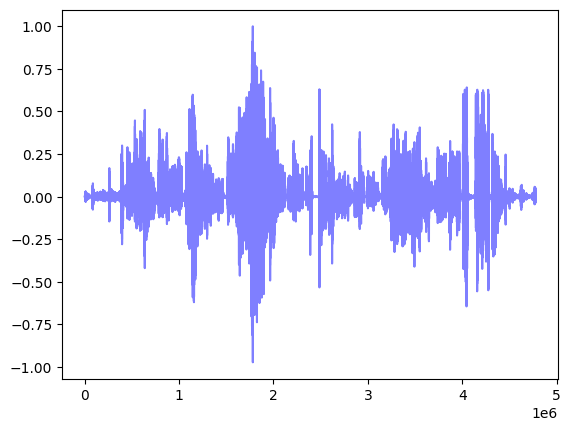

In [10]:
## plot the audio
import matplotlib.pyplot as plt
plt.plot(np.arange(0, len(mixed_audio), 1), mixed_audio, alpha=0.5, color='blue')

In [29]:
#clip.write_videofile('test2.mov', codec='prores', audio_codec='pcm_s32le')
# clip.audio = audio_as_clip # does not work any more no idea why
clip.write_videofile('mm-test-clean-audio.mp4')

Moviepy - Building video mm-test-clean-audio.mp4.
MoviePy - Writing audio in mm-test-clean-audioTEMP_MPY_wvf_snd.mp3


chunk:   0%|                                 | 0/2173 [00:00<?, ?it/s, now=None]

IndexError: index -100001 is out of bounds for axis 0 with size 0

In [32]:
import ffmpeg

def remux_video(video_file, audio_file):
    input_video = video_file
    new_audio = audio_file
    output_video = video_file[0:-4] + "-mixed" + video_file[:-4]
    
    # Define the input video and audio streams
    input_video_stream = ffmpeg.input(input_video)
    input_audio_stream = ffmpeg.input(new_audio)
    
    # Use the 'map' option to copy the video stream and the audio stream
    output_stream = ffmpeg.output(input_video_stream['v'], input_audio_stream['a'], output_video, c='copy')
    
    # Run the ffmpeg command to replace the audio using the copy codec
    ffmpeg.run(output_stream, overwrite_output=True)


ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.1.0.2.5)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopen

(None, None)

4752001 4776000 4776000 4752001
(4752001,) (4776000,)


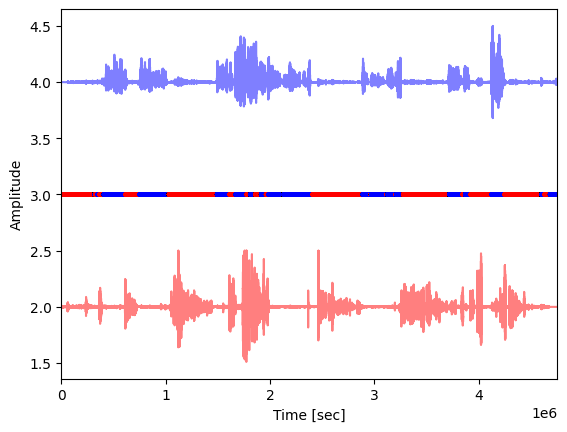

In [150]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import librosa

matthew_audio = clip1
mark_audio = clip2

if len(matthew_audio) > len(mark_audio):
    matthew_audio = matthew_audio[0:len(mark_audio)]
else:
    mark_audio = mark_audio[0:len(matthew_audio)]
    

# Ensure same sampling frequency

# Calculate moving average loudness over 0.1 sec window 
window_size = round(0.5 * sr)  
matthew_loudness = scipy.signal.convolve(np.abs(matthew_audio), np.ones(window_size)/window_size, mode='valid')
mark_loudness = scipy.signal.convolve(np.abs(mark_audio), np.ones(window_size)/window_size, mode='valid')

# Generate overlay colors
colors = ['blue' if l1 > l2 else 'red' for l1, l2 in zip(matthew_loudness, mark_loudness)]
# Plot waveforms and overlay
time = np.arange(len(colors))

print(len(colors), len(matthew_audio), len(mark_audio), len(time))
print(time.shape, matthew_audio.shape)
offset = len(matthew_audio) - len(time)
plt.plot(time, matthew_audio[offset:] + 4, alpha=0.5, color='blue')
plt.plot(time, mark_audio[offset:] + 2, alpha=0.5, color='red')  
plt.scatter(time, np.zeros_like(time)+3, c=colors, s=3)
plt.xlim([time[0], time[-1]])
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')
plt.show()

In [27]:
(clip.duration, audio_as_clip.duration, audio_as_clip_clean.duration)

(98.51389583333334, 100.49000000000001, 100.49000000000001)

In [21]:
len(clip1) / 48000

99.5